In [235]:
# Imports 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder, StandardScaler,OrdinalEncoder
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score , recall_score , f1_score  , confusion_matrix , ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score , classification_report , roc_auc_score, RocCurveDisplay
# Feature Engineering   
from sklearn.decomposition import PCA

In [236]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
    
    
    
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [237]:
def convert_probs_to_preds(probabilities, threshold, pos_class=1):
  """Converts float value probabilities into int value predictions.
  If the probability of class 1 is greater than the threshold, the prediction is 1
  Otherwise the prediction is 0
  pos_class determines the index of the positive class in the array of probabilies"""
  predictions = [1 if prob[pos_class] > threshold else 0 for prob in probabilities]
  return predictions

In [238]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [239]:
df=pd.read_csv('cirrhosis.csv')
df=df.drop(columns="ID")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage     

In [240]:
df['Status'].replace({'CL':'C'},inplace=True)
#convert target : status of the patient C (censored)or D (death)
df['Status'].replace({'C':0,'D':1},inplace=True)

In [241]:
df['Status'].value_counts()

0    257
1    161
Name: Status, dtype: int64

# Preprocesing for Machine Learning¶

In [242]:
## Define X and y
y = df['Status']
X=df.drop(columns="Status")

In [243]:
# Perfoming a train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [244]:
#  Create the preprocessing pipeline for numeric data
numeric_columns=X_train.select_dtypes("number").columns
# Scaler
scaler=StandardScaler()
#imputer
imputer=SimpleImputer(strategy="median")
# Instantiate the pipeline
numeric_pipe= make_pipeline(imputer,scaler)
# Make the tuple for ColumnTransformer
numeric_tuple= ("numarical",numeric_pipe ,numeric_columns )
print(numeric_tuple)

('numarical', Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())]), Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object'))


In [245]:
# Create the preprocessing pipeline for categorical  data
categorical_columns =X_train.select_dtypes("object").columns
imputer_categorical = SimpleImputer(strategy="constant",fill_value="NA")
#OneHotEncoder
oht_categorical = OneHotEncoder(drop="if_binary", sparse_output=False )
# Instantiate the pipeline
categorical_pipeline= make_pipeline(imputer_categorical,oht_categorical)
# Make the tuple for ColumnTransformer
categorical_tuple= ("categorical" , categorical_pipeline , categorical_columns)

In [246]:
# Create the preprocessing ColumnTransformer
preprocessing_Column= ColumnTransformer([numeric_tuple,categorical_tuple],  remainder="drop", verbose_feature_names_out=False)
preprocessing_Column 

ColumnTransformer(transformers=[('numarical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False))]),
                                 Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))],
                  verbose_feature_names_out=False)

In [247]:
y_train.value_counts(normalize="true")

0    0.626198
1    0.373802
Name: Status, dtype: float64

In [248]:

preprocessing_Column.fit(X_train)

ColumnTransformer(transformers=[('numarical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False))]),
                                 Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))],
                  verbose_feature_names_out=False)

In [249]:

X_train_tf = preprocessing_Column.transform(X_train)
X_test_tf = preprocessing_Column.transform(X_test)

# Feature Engineering  

## PCA 

* Choosing the Number of Components to Return

In [250]:
# Initialize and fit PCA
pca= PCA()
pca.fit(X_train_tf, y_train)

PCA()

In [251]:
# Determine how much variance is explained by each PC
explained = pd.Series(pca.explained_variance_ratio_, name='Explained Variance Ratio')
explained



0     2.112645e-01
1     1.355075e-01
2     7.846289e-02
3     7.320000e-02
4     6.592629e-02
5     5.883308e-02
6     5.398404e-02
7     5.159919e-02
8     4.765141e-02
9     4.388832e-02
10    3.796331e-02
11    3.326678e-02
12    2.589864e-02
13    2.320824e-02
14    1.964924e-02
15    1.577643e-02
16    1.070265e-02
17    5.846196e-03
18    5.444989e-03
19    1.926381e-03
20    5.419308e-33
21    1.138050e-33
22    1.138050e-33
23    1.138050e-33
24    1.138050e-33
25    1.138050e-33
26    1.138050e-33
27    4.056620e-34
Name: Explained Variance Ratio, dtype: float64

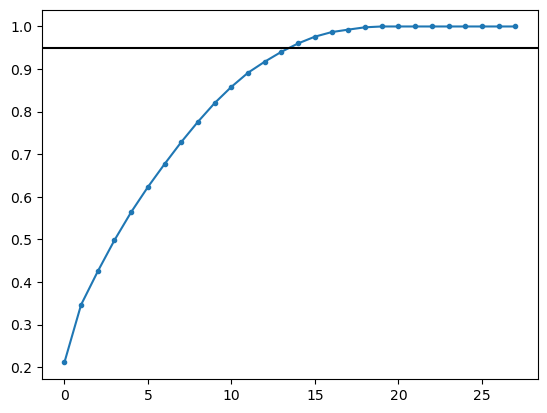

In [252]:
# plot the cumulative sum of the percentage of explained variance for each component and those before it.
ax = explained.cumsum().plot(marker='.')
# add a line to mark .95 (or 90%) variance explained
ax.axhline(.95, color='k');



In [253]:
# Define PCA to address 95% of the variance
pca90= PCA(n_components=3)
pca90.fit(X_train_tf)
X_train_pca90 = pca90.transform(X_train_tf)
X_test_pca90 = pca90.transform(X_test_tf)


In [254]:
# Instantiate default random forest model , 95% of the variance
rf_pca90 =RandomForestClassifier(random_state = 42,class_weight="balanced")
# Model Pipeline
rf_pca90.fit(X_train_pca90,y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       196
           1       1.00      1.00      1.00       117

    accuracy                           1.00       313
   macro avg       1.00      1.00      1.00       313
weighted avg       1.00      1.00      1.00       313



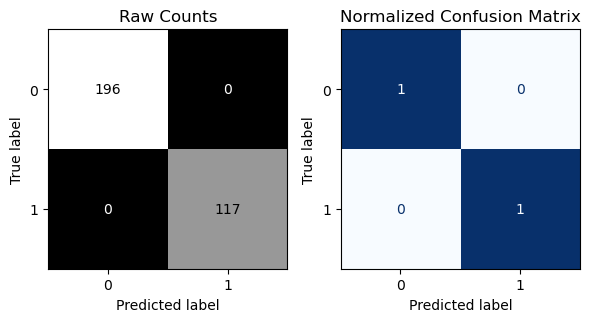


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        61
           1       0.77      0.68      0.72        44

    accuracy                           0.78       105
   macro avg       0.78      0.77      0.77       105
weighted avg       0.78      0.78      0.78       105



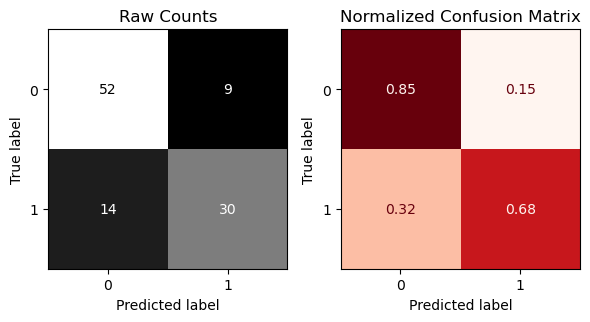

In [255]:
# Use custom function to evalute the model, 95% of the variance
evaluate_classification(rf_pca90,X_train_pca90,y_train, X_test_pca90, y_test)

In [256]:
X_test_pca90.shape

(105, 3)

* Without PCA:

  * precision 0: 84%
  * precision 1: 89%
  * Recall for class 0: 93%
  * Recall for class 1: 75%
  * F1 scale (F1 score) for class 0: 88%
  * F1-score for Category 1: 81%
  * Overall accuracy: 86%
* With PCA:

   * precision 0: 79%
   * precision for class 1: 77%
   * Recall for class 0: 85%
   * Recall for class 1: 68%
   * F1 scale (F1 score) for class  0: 82%
   * F1 scale (F1 score) for class 1: 72%
   * Overall (accuracy): Accuracy 78%
 
* note: It should be noted that the use of PCA resulted in a decrease in the overall performance of the model compared to the model in which PCA was not used.
*  Dimensionality reduction using PCA can have a positive impact in some cases, such as reducing training time or improving model interpretability, but it must be ensured that performance losses do not outweigh the potential benefits from dimensionality reduction.

##  clustering

In [257]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: 

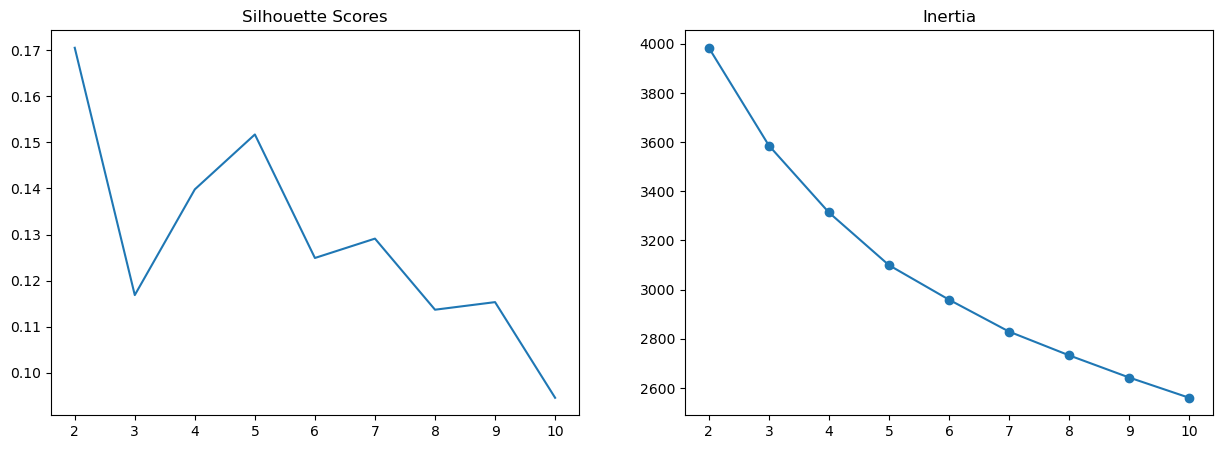

In [258]:
# Iterate over a range of k clusters to find the optimal number of clusters
ks = range (2,11)

sils = []
inertias = []
for k in ks:
  kmeans = KMeans(n_clusters=k, n_init = 15, random_state=42)
  kmeans.fit(X_train_tf)
  sils.append(silhouette_score(X_train_tf, kmeans.labels_))
  inertias.append(kmeans.inertia_)
#plot inertias and silhouette scores for each number of clusters.
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(ks, sils)
axes[0].set_title('Silhouette Scores')
axes[0].set_xticks(ks)
axes[1].plot(ks, inertias,marker = "o")
axes[1].set_title('Inertia')
axes[1].set_xticks(ks);

In [259]:
kmeans = KMeans(n_clusters=5,n_init=15 , random_state=42)
kmeans.fit(X_train_tf)

C:\Users\Ashraf\anaconda3\envs\dojo-env\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


KMeans(n_clusters=5, n_init=15, random_state=42)

In [260]:
X_trsin_cluster =kmeans.fit

In [261]:
X_train_tf['cluster']=kmeans.labels_
cluster_groups = X_train_tf.groupby('cluster',as_index=False).mean()
cluster_groups

,cluster,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug_D-penicillamine,Drug_NA,Drug_Placebo,Sex_M,Ascites_N,Ascites_NA,Ascites_Y,Hepatomegaly_N,Hepatomegaly_NA,Hepatomegaly_Y,Spiders_N,Spiders_NA,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,0,1.096719,0.275990,-0.342370,-0.127780,0.403973,0.239665,3.522954,-0.216641,0.211089,0.439113,0.033408,-0.310995,0.600000,0.0,0.400000,0.266667,1.000000,0.0,0.000000,0.600000,0.0,0.400000,0.800000,0.0,0.200000,1.000000,0.000000,0.000000
1,1,-0.214176,0.196777,0.011981,-0.234167,-0.128022,-0.247391,-0.297505,-0.149419,-0.187210,-0.183799,0.000934,-0.010790,0.000000,1.0,0.000000,0.085714,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.842857,0.157143,0.000000
2,2,-0.528754,0.315905,0.029255,-0.219510,-0.602604,0.510734,-0.083802,0.313112,-0.289502,-0.606415,0.652143,0.846138,0.462687,0.0,0.537313,0.194030,0.820896,0.0,0.179104,0.149254,0.0,0.850746,0.522388,0.0,0.477612,0.731343,0.119403,0.149254
3,3,-0.790441,-0.485761,2.216395,2.051980,-0.453716,1.225863,0.555811,1.454491,1.462070,0.159800,0.550814,0.447856,0.407407,0.0,0.592593,0.074074,0.814815,0.0,0.185185,0.259259,0.0,0.740741,0.444444,0.0,0.555556,0.740741,0.148148,0.111111
4,4,0.412761,-0.193764,-0.429148,-0.167074,0.414379,-0.399964,-0.309038,-0.347320,-0.075678,0.317869,-0.441284,-0.472859,0.567164,0.0,0.432836,0.082090,0.992537,0.0,0.007463,0.738806,0.0,0.261194,0.843284,0.0,0.156716,0.947761,0.052239,0.000000


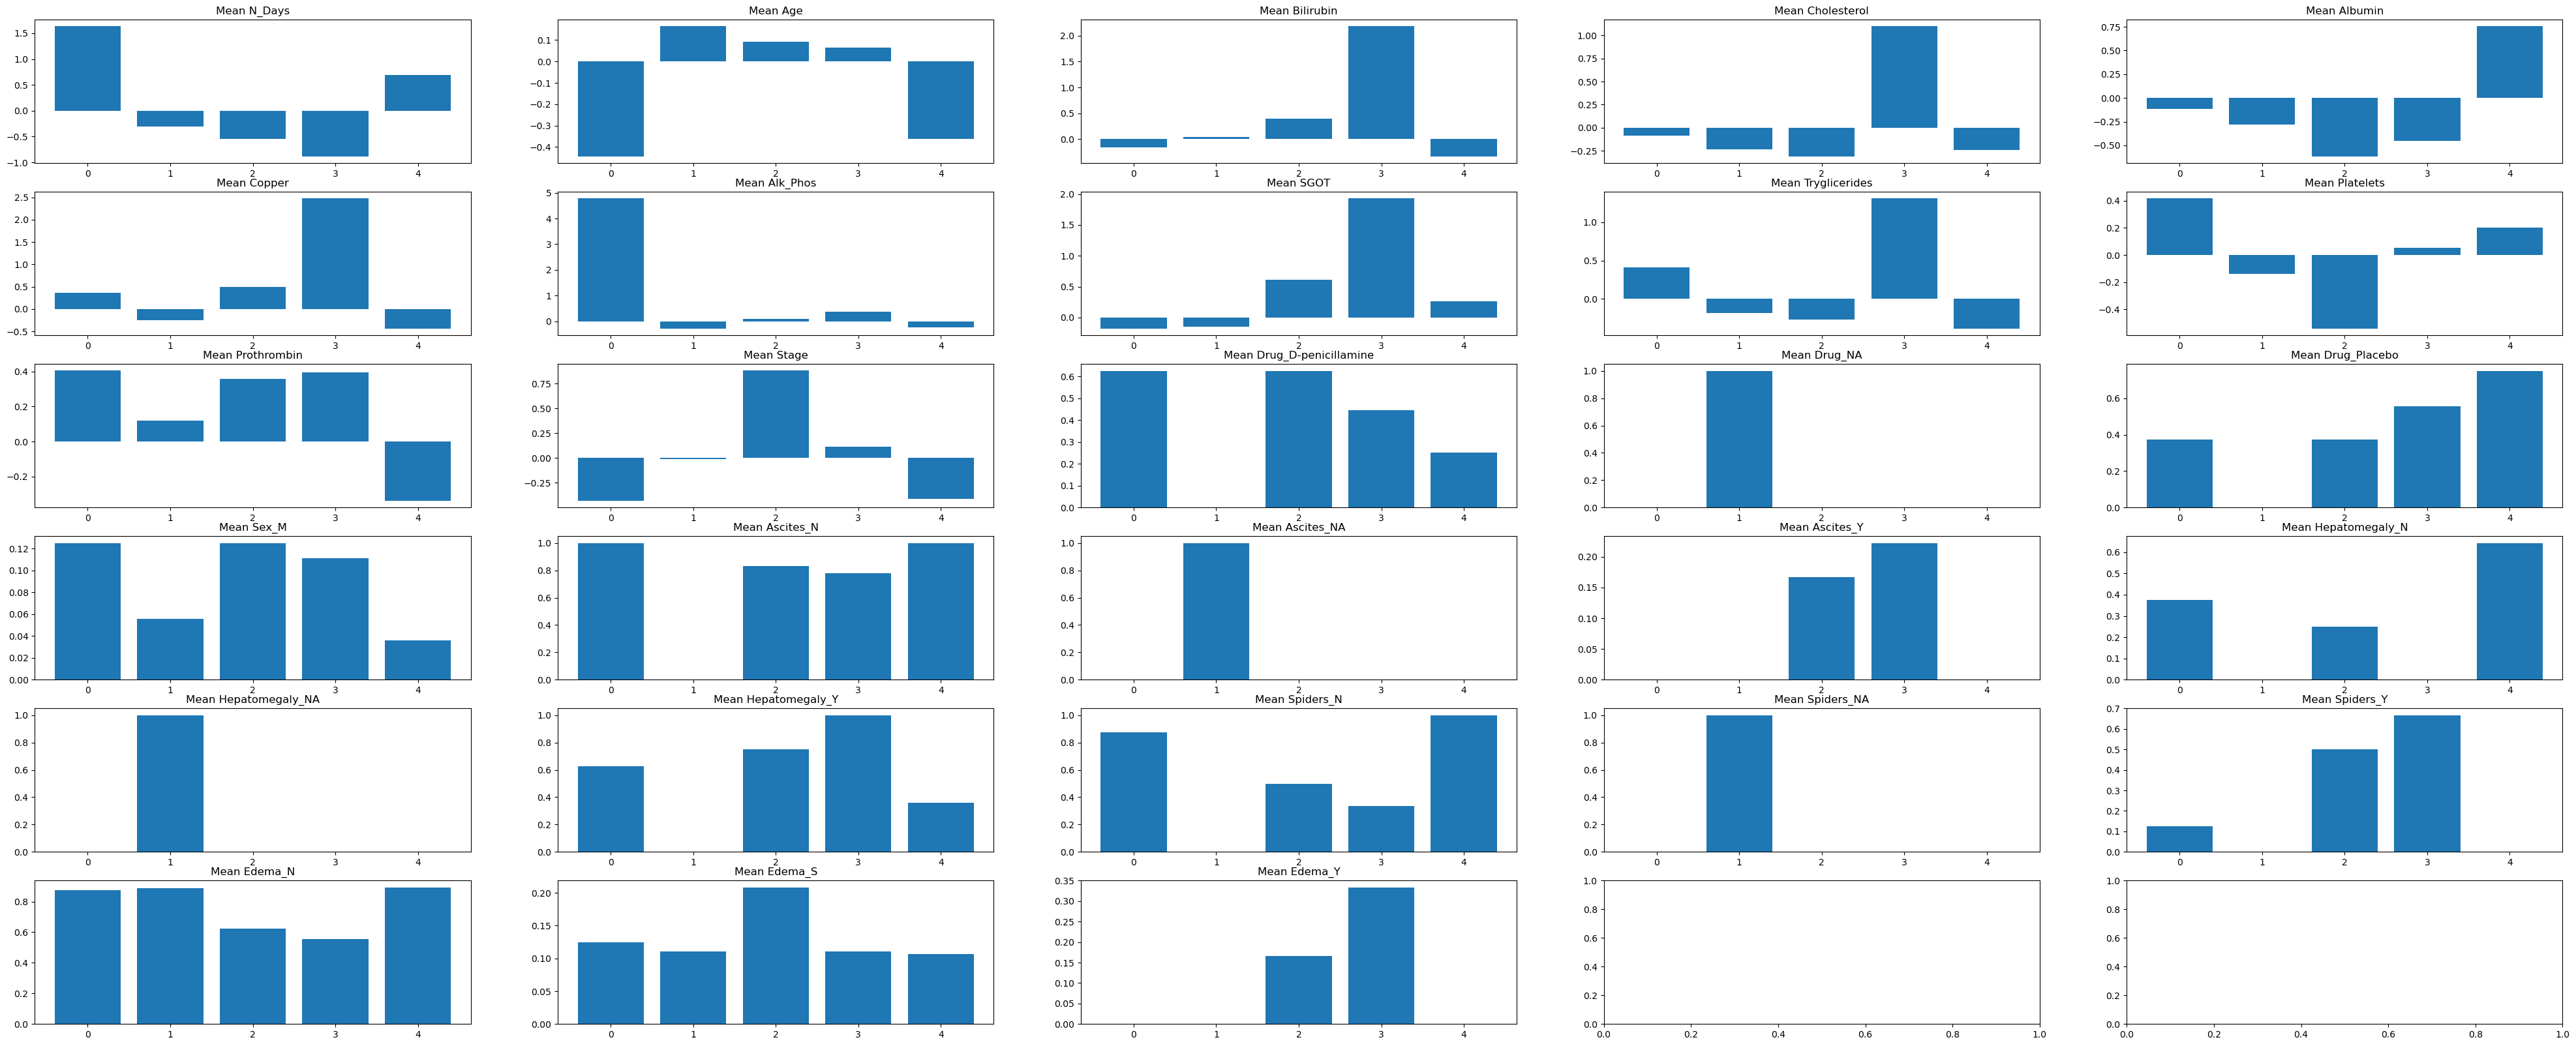

In [287]:
# Visualize means 
fig, axes = plt.subplots(6,5, figsize = (50,20))
# fig is an array of dimensions 3,4.  axes.ravel() will flatten it to 12,1
axes = axes.ravel()
# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')
plt.savefig('means_plot.png')


## Moderate-moderate cirrhosis : cluster 0   المتوسط المعتدل  
* Liver condition: moderate to good, without significant liver damage.
* Symptoms: No ascites or edema, which indicates no accumulation of fluid in the body.
* Liver function: good balance, as SGOT and Prothrombin are at normal levels.
* Biochemistry: Some slight changes in the levels of Albumin, Copper, and Alkaline Phosphatase, but they do not indicate serious problems.
* Blood vessels: No increase in triglycerides levels.
   There is a possibility of structural changes in the liver, but without noticeable symptoms


## Liver without damage : cluster1 
* Liver condition: good, without noticeable liver damage.
* Symptoms: No ascites or edema, which indicates no accumulation of fluid in the body.
* Liver function: good, as SGOT and prothrombin are at normal levels.
* Biochemistry: Some slight changes in Copper and Alkaline Phosphatase levels, but they do not indicate serious problems.
* Blood vessels: No increase in triglycerides levels.
* Imaging: No possibility of structural changes in the liver.

## Advanced liver cirrhosis : cluster 2 
* Liver condition: high in terms of fibrosis and hypertrophy.
* Symptoms: the presence of ascites, edema, and arachnoid tumor in most cases.
* Liver function: Significant changes in liver function with an increase in SGOT and Bilirubin, and an increase in prothemin.
* Biochemistry: Changes in albumin and copper levels.
* Blood vessels: Triglycerides in low levels.

##  Advanced cirrhosis with complications :  cluster3  متقدم  
* Liver condition: high in terms of fibrosis and hypertrophy.
* Symptoms: the presence of ascites, edema, and arachnoid tumor in most cases.
* Liver function: Significant changes in liver function with a significant increase in SGOT and Bilirubin, and a significant increase in prothemin.
*Biochemistry: Increase in levels of cholesterol, triglycerides, and copper.
* Blood vessels: increased levels of triglycerides.
*This summary indicates a very serious liver condition that requires urgent medical attention and care.








# Normal liver  : cluster 4 

* Liver condition: normal, without signs of fibrosis or hepatomegaly.
* Symptoms: No ascites or edema, and few arachnoid tumors.
* Liver function: Many indicators are within the normal range, such as Bilirubin, Cholesterol, and SGOT levels.
* Biochemistry: A slight increase in the levels of Alkaline Phosphatase, and a decrease in the levels of Copper and Prothrombin.
* Vascular: Good levels of triglycerides.

In [263]:
X_train_tf=X_train_tf.drop(columns='cluster')


In [264]:
X_train_prodict= kmeans.predict(X_train_tf)
X_train_prodict

array([4, 4, 4, 1, 2, 4, 4, 3, 2, 4, 3, 3, 0, 4, 3, 4, 4, 4, 2, 2, 1, 4,
       4, 4, 3, 4, 4, 4, 1, 1, 4, 1, 1, 2, 4, 1, 1, 3, 4, 4, 1, 3, 4, 3,
       4, 4, 4, 1, 1, 4, 1, 2, 4, 4, 4, 2, 4, 4, 2, 4, 2, 4, 1, 4, 2, 4,
       4, 4, 4, 4, 2, 2, 4, 1, 4, 2, 1, 4, 4, 1, 2, 1, 3, 4, 4, 4, 3, 4,
       2, 3, 1, 4, 1, 3, 0, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 2, 4,
       1, 4, 1, 2, 1, 4, 1, 1, 3, 2, 4, 3, 4, 3, 0, 2, 4, 2, 2, 2, 4, 2,
       4, 4, 4, 4, 1, 2, 1, 2, 4, 1, 1, 2, 1, 4, 2, 4, 4, 1, 2, 2, 4, 2,
       4, 1, 4, 3, 1, 4, 1, 4, 1, 4, 1, 4, 3, 2, 3, 4, 4, 4, 0, 4, 2, 1,
       2, 2, 4, 0, 3, 1, 1, 4, 0, 1, 4, 4, 4, 1, 2, 4, 1, 4, 4, 1, 4, 4,
       4, 2, 4, 2, 0, 2, 2, 2, 1, 3, 1, 2, 4, 4, 4, 1, 2, 3, 4, 4, 4, 4,
       4, 0, 4, 2, 1, 1, 3, 4, 1, 2, 2, 4, 4, 1, 2, 1, 1, 4, 4, 4, 2, 2,
       4, 3, 4, 2, 4, 2, 0, 2, 3, 0, 0, 2, 2, 1, 0, 1, 2, 2, 2, 1, 4, 4,
       2, 1, 1, 4, 4, 1, 1, 3, 0, 1, 0, 4, 4, 1, 2, 4, 0, 2, 1, 4, 2, 2,
       1, 4, 4, 4, 1, 3, 1, 4, 4, 4, 2, 2, 1, 2, 1,

In [265]:
X_test_prodict=kmeans.predict(X_test_tf)
X_test_prodict

array([1, 1, 1, 0, 2, 0, 4, 2, 2, 1, 2, 1, 4, 1, 1, 0, 1, 1, 0, 1, 1, 2,
       1, 2, 4, 4, 1, 2, 1, 4, 4, 1, 4, 2, 2, 2, 2, 4, 2, 3, 4, 4, 4, 2,
       3, 4, 1, 4, 2, 2, 2, 2, 4, 1, 1, 4, 2, 3, 1, 1, 3, 1, 4, 2, 2, 1,
       0, 3, 1, 1, 1, 4, 1, 3, 4, 1, 1, 2, 3, 0, 4, 4, 3, 4, 1, 0, 2, 4,
       1, 4, 3, 1, 1, 4, 0, 4, 4, 1, 1, 2, 1, 4, 1, 2, 4])

In [266]:
X_test_tf['cluster']=X_test_prodict
cluster_groups = X_test_tf.groupby('cluster',as_index=False).mean()
cluster_groups

,cluster,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Drug_D-penicillamine,Drug_NA,Drug_Placebo,Sex_M,Ascites_N,Ascites_NA,Ascites_Y,Hepatomegaly_N,Hepatomegaly_NA,Hepatomegaly_Y,Spiders_N,Spiders_NA,Spiders_Y,Edema_N,Edema_S,Edema_Y
0,0,1.633724,-0.445161,-0.160676,-0.088089,-0.115955,0.368047,4.780604,-0.183806,0.411584,0.416840,0.405390,-0.432953,0.625000,0.0,0.375000,0.125000,1.000000,0.0,0.000000,0.375000,0.0,0.625000,0.875000,0.0,0.125000,0.875000,0.125000,0.000000
1,1,-0.302322,0.164530,0.044588,-0.234167,-0.277895,-0.247391,-0.297505,-0.149419,-0.187210,-0.139273,0.118367,-0.010790,0.000000,1.0,0.000000,0.055556,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.000000,1.0,0.000000,0.888889,0.111111,0.000000
2,2,-0.550466,0.093017,0.391278,-0.314572,-0.619622,0.499196,0.088389,0.607768,-0.264956,-0.543822,0.358031,0.880443,0.625000,0.0,0.375000,0.125000,0.833333,0.0,0.166667,0.250000,0.0,0.750000,0.500000,0.0,0.500000,0.625000,0.208333,0.166667
3,3,-0.889475,0.065742,2.182348,1.099767,-0.453716,2.476657,0.381946,1.929079,1.311894,0.054133,0.393909,0.114295,0.444444,0.0,0.555556,0.111111,0.777778,0.0,0.222222,0.000000,0.0,1.000000,0.333333,0.0,0.666667,0.555556,0.111111,0.333333
4,4,0.696198,-0.362588,-0.338722,-0.239779,0.755124,-0.444372,-0.251040,0.257737,-0.390332,0.199902,-0.340049,-0.412850,0.250000,0.0,0.750000,0.035714,1.000000,0.0,0.000000,0.642857,0.0,0.357143,1.000000,0.0,0.000000,0.892857,0.107143,0.000000


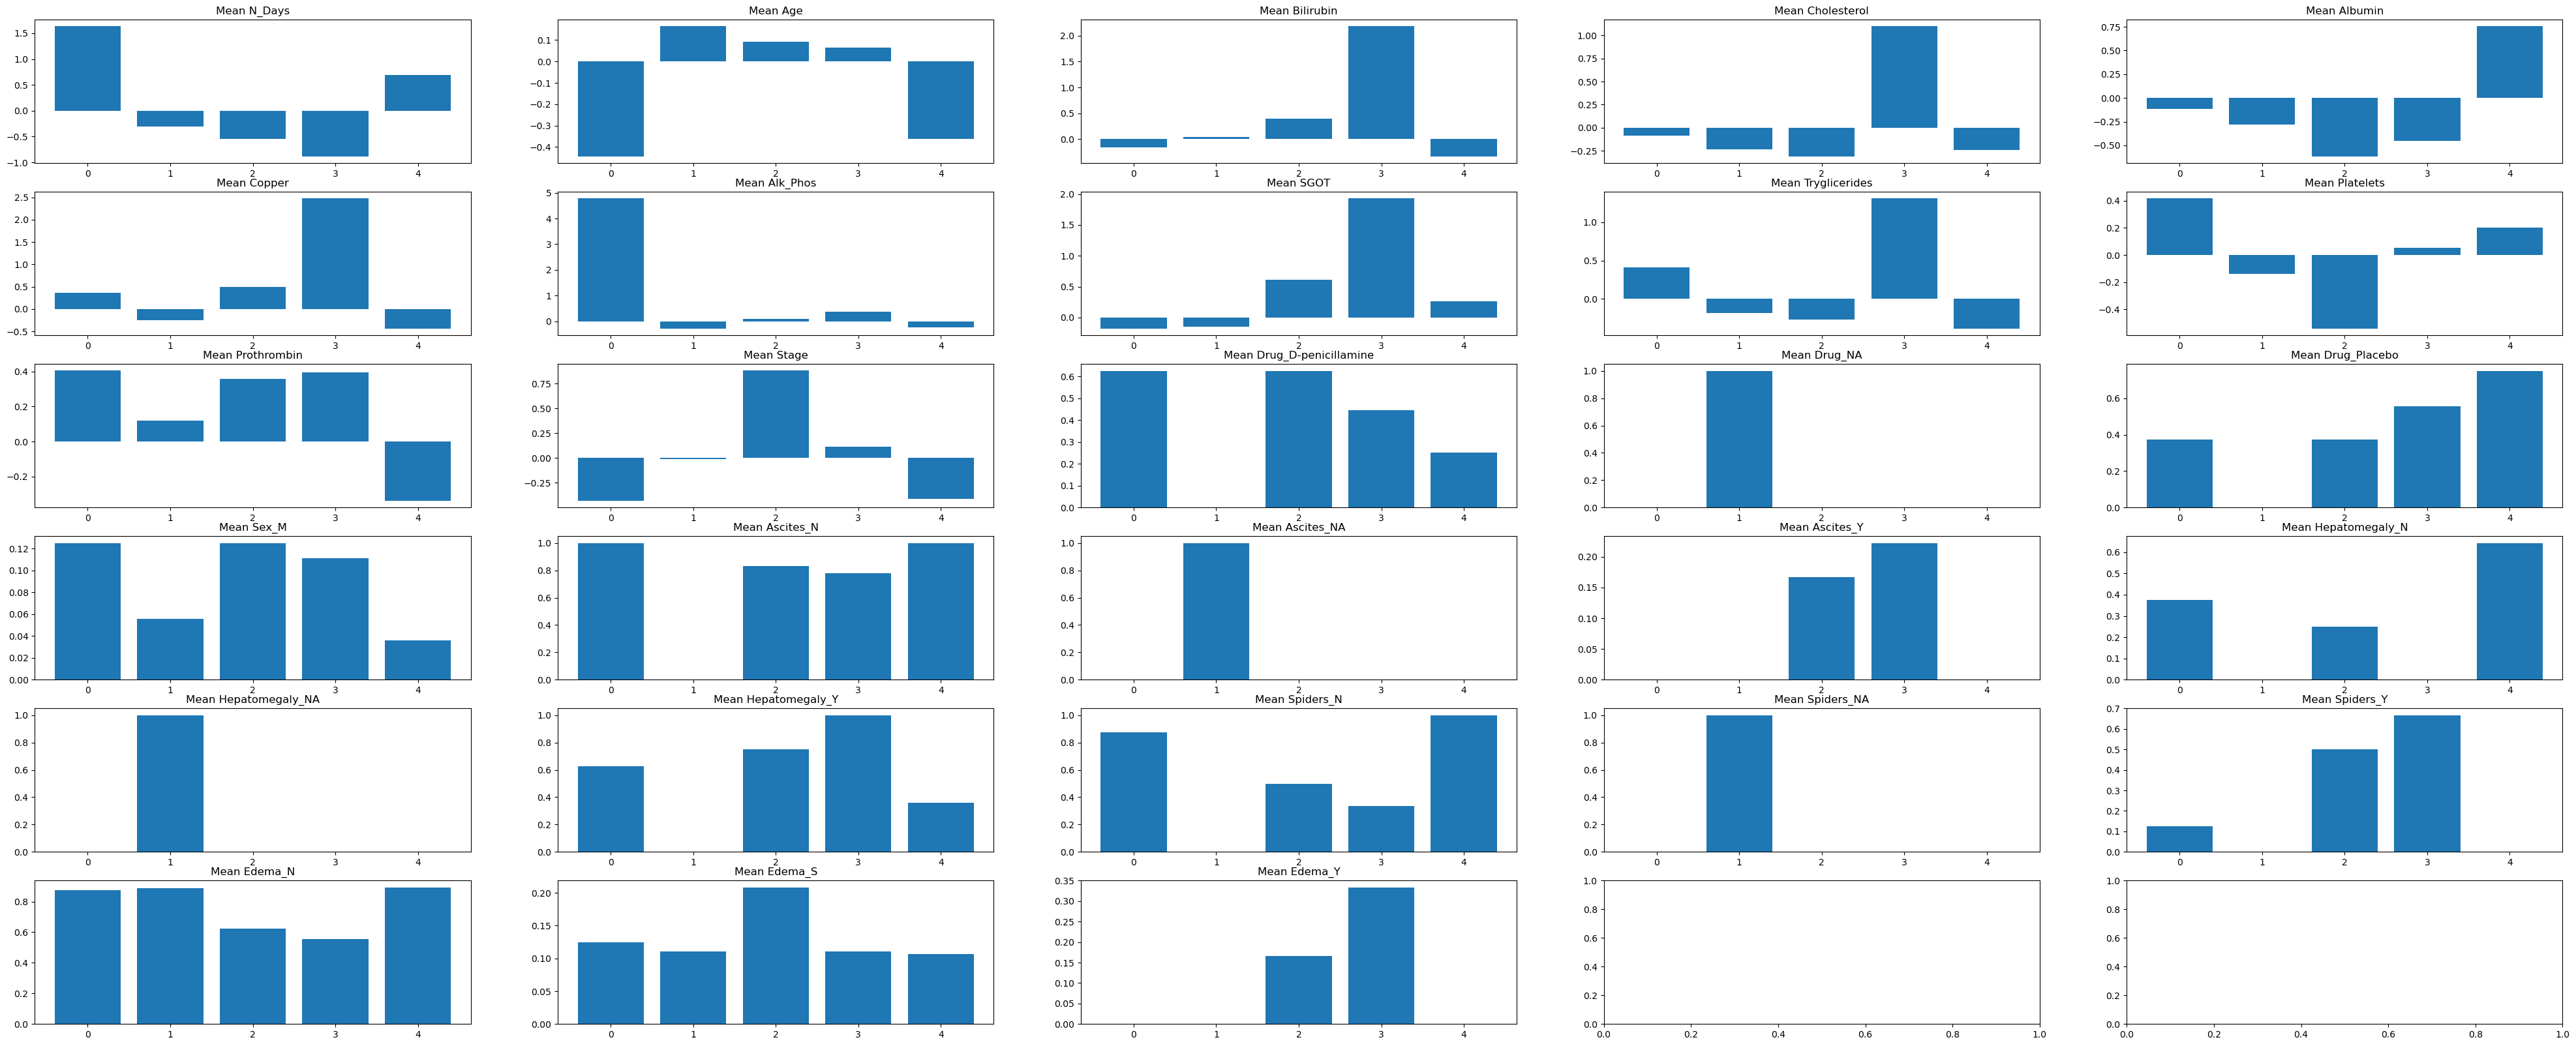

In [267]:
# Visualize means 
fig, axes = plt.subplots(6,5, figsize = (50,20))
# fig is an array of dimensions 3,4.  axes.ravel() will flatten it to 12,1
axes = axes.ravel()
# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[1:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')

## Filtering

<Axes: >

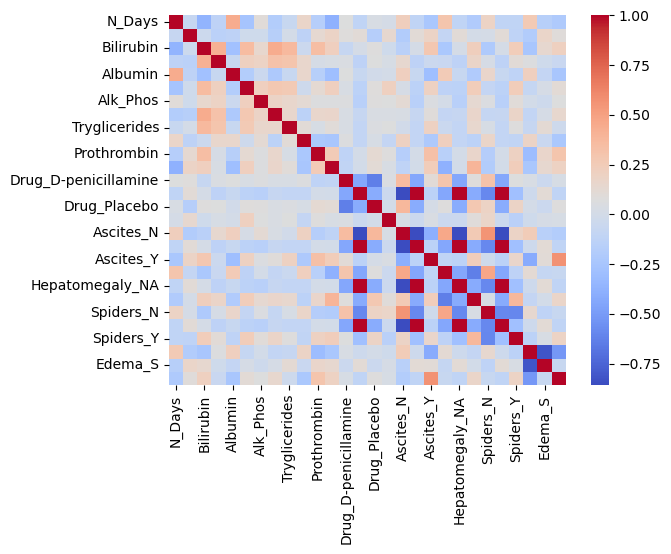

In [268]:
# Make a correlation heatmap of all features
corr=X_train_tf.corr()
plt.Figure((15,15))
sns.heatmap(corr,cmap='coolwarm')

In [269]:
from collinearity import SelectNonCollinear
from sklearn.feature_selection import f_classif

In [270]:
# Instantiate the selector, indicate theshold for r, also include the appropriate scoring metric for the task
selctor =  SelectNonCollinear(correlation_threshold=0.5 , scoring=f_classif,)
selctor.fit_transform(X_train_tf.values ,y_train.values )

array([[ 0.82710028,  1.09467267, -0.35808356, ...,  0.        ,
         0.        ,  1.        ],
       [ 2.20027707, -0.64801159, -0.57022266, ...,  0.        ,
         0.        ,  1.        ],
       [-0.30530031, -0.94376143, -0.2166575 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.32693255, -0.03691404, -0.47593862, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.88259167,  0.29115957, -0.38165457, ...,  0.        ,
         0.        ,  1.        ],
       [-1.6991688 , -0.17715342, -0.12237346, ...,  1.        ,
         1.        ,  0.        ]])

In [271]:
non_collinear =selctor.get_support()

In [272]:
non_collinear.count(True)

19

In [273]:
non_collinear.count(False)

9

In [276]:
X_test_tf = X_test_tf.drop(columns='cluster')

In [278]:
# Filter training data
training_data_to_keep = X_train_tf.values[:, non_collinear]
# Filter column names
columns = np.array(X_train_tf.columns)[non_collinear]
# Make traing data into a dataframe
X_train_no_corr = pd.DataFrame(training_data_to_keep, columns = columns)

# Filter testing data
test_data_to_keep = X_test_tf.values[:, non_collinear]
# Make test data into a dataframe
X_test_no_corr = pd.DataFrame(test_data_to_keep, columns = columns)



----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       196
           1       1.00      1.00      1.00       117

    accuracy                           1.00       313
   macro avg       1.00      1.00      1.00       313
weighted avg       1.00      1.00      1.00       313



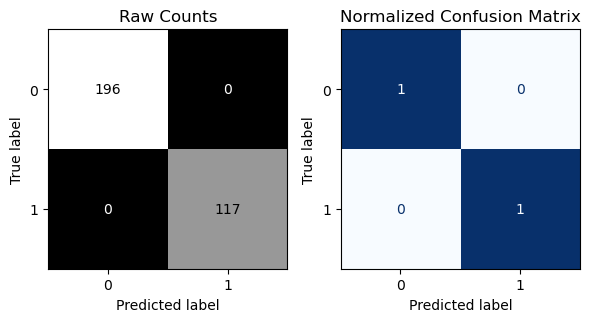


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        61
           1       0.85      0.66      0.74        44

    accuracy                           0.81       105
   macro avg       0.82      0.79      0.80       105
weighted avg       0.82      0.81      0.80       105



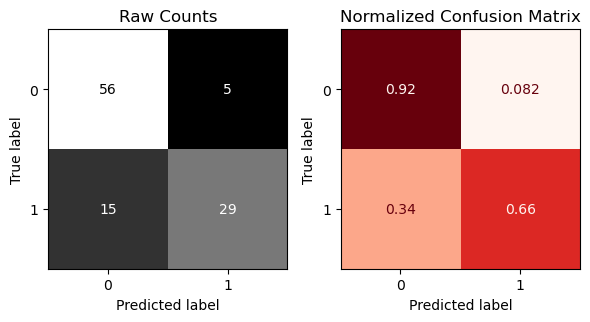

In [279]:
# Test the performance
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_no_corr, y_train)
evaluate_classification(rf_clf, X_train_no_corr, y_train, X_test_no_corr, y_test)



Without Filtering :

* precision 0: 84%
* precision 1: 89%
* Recall for class 0: 93%
* Recall for class 1: 75%
* F1 scale (F1 score) for class 0: 88%
* F1-score for Category 1: 81%

With Filtering:

* precision 0: 79%
* precision for class 1: 85%
* Recall for class 0:92%
* Recall for class 1: 66%
* F1 scale (F1 score) for class 0: 85%
* F1 scale (F1 score) for class 1: 74%


In [281]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rf_clf,X_train_no_corr, y_train ,n_repeats =5, random_state =42)
r.keys()


dict_keys(['importances_mean', 'importances_std', 'importances'])

In [283]:
## can make the mean importances into a series
perm_importances = pd.Series(r['importances_mean'],index=X_train_no_corr.columns,
                           name = 'permutation importance')
perm_importances.head()


N_Days         0.081789
Age            0.019169
Bilirubin      0.039617
Cholesterol    0.004473
Albumin        0.003834
Name: permutation importance, dtype: float64

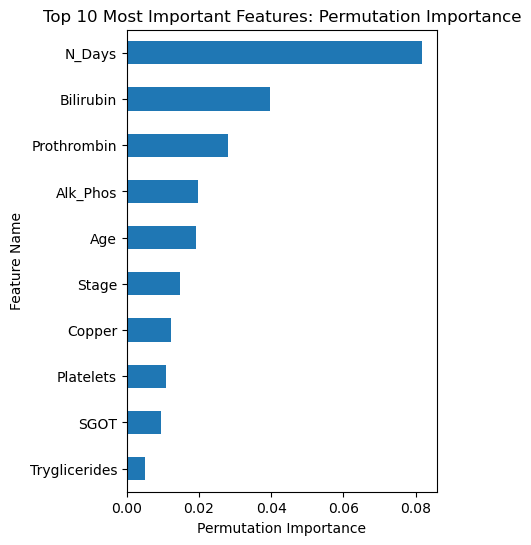

In [284]:
ax = perm_importances.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Permutation Importance',
       title='Top 10 Most Important Features: Permutation Importance');
plt.savefig("perm_importances.png", bbox_inches='tight')

* SGOT (or AST) is an enzyme found in the liver and is used to evaluate liver and heart function. A high SGOT level can indicate liver damage. SGOT analysis is important for diagnosing liver-related diseases and monitoring patients' condition, and can influence the predictions of the classification model in studying medical data.